# Lab 6 - Gaussian Process

In general, Gaussian Process (GP) is a stochastic process used for modeling data, which were observed over time, space or both. Main thing that can characterise GP is that is a kind of generalization of normal probability distributions, where each of them describes a random variable (scalar or vector if we deal with multivariate distribution).

Following definition captures the essence of Gaussian Process: 

A Gaussian process is a collection of random variables, any Gaussian process finite number of which have a joint Gaussian distribution.


If we define mean function $m(x)$ and the covariance function mean function $k(x,x')$ of a real process $f(x)$ as:
\begin{equation}
m(x) = E[f(x)]
\end{equation}
\begin{equation}
k(x,x') = E[f(x)-m(x))(f(x')-m(x'))]
\end{equation}
Then we can define GP can as:
\begin{equation}
\label{eq:gpmain}
f(x) \sim GP(m(x),k(x,x'))
\end{equation}


GP can be fully determined by only declaring mean and covariance functions. Mean in most cases is set to value "0", because such a setting can be useful, simplifies matters and is not a difficult requirement to fulfill. Of course, there are examples
where we would like to change the mean e.g. for better model interpretability or the 
specification of our prior. Covariance function (also called kernel function) represents
a similarity between data points. Note that usually covariance is chosen from
the set of already defined functions. The one should at least pick one, which represents
prior beliefs of the problem. But in fact, covariance function can be any function, which
has the property of generating a positive definite covariance matrix. Anyway, creating 
and defining new covariance functions, which will simultaneously be correct and have a
practical usage, can be really difficult

The most basic and common kernel function is Radial Basis Function (RBF), which is defined with the formula:
\begin{equation}
\label{eq:rbf}
k\left(x_{i}, x_{j}\right)=\exp \left(-\frac{d\left(x_{i}, x_{j}\right)^{2}}{2 l^{2}}\right)
\end{equation}
Its main property is that its value is usually only dependent on the distance from the specified point. The parameter which RBF kernel uses is $l$ as a characteristic length scale. RBF is infinitely differentiable. That means the GP with this kernel has a mean square derivatives for all orders. Other worth noting kernel, in terms of our classess is one from exponentiated quadratic family, where $\rho$ is length-scale and $\alpha$ is marginal deviation:
$$
k\left(x_{1}, x_{2}\right)=\alpha^{2} \exp \left(-\frac{1}{2}\left(\frac{\left|x_{1}-x_{2}\right|}{\rho}\right)^{2}\right)
$$
Gaussian Process is growing in popularity of usage in domains connected with statistics and machine learning. It is especially efficient solution, while we are dealing with a problem of obtaining data e.g. for faulty cases or just an overall lack of comprehensive data and if we want to obtain not only prediction but also confidence interval. Main areas where GP is used for are: regression, prediction, classification and identification. On this classes we will focuse on a simple task of regression.

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import random

### Task 1: simulating from Gaussian Process model

To make any simulations, first you need a set of observations:

In [2]:
#Observed data
x_obs = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
y_obs = [0.328572824089476, 4.20607004111644, 1.35507551134795,
0.161608755204364, -5.42320349780782, -3.05851276224202, -0.0764172642034502,
-4.55218472276499, -0.902226297922731, -5.8609833528976, -1.05854090910473]

Model also needs sampling space and the indexes of where our observed data resides there. 
For your convenience, we provide them below:

In [3]:
x_predict = np.linspace(-11,11,551,endpoint=True)
observed_idx = [26, 76, 126, 176, 226, 276, 326, 376, 426, 476, 526]

In this example we are using kernel from exponentiated quadratic family, so we need to provide its hyperparameters (alpha and rho). Moreover, for sample generation, we would like to set a sigma value. Let's start with some arbitrarily selected parameters:

In [4]:
alpha = 3
rho = 5.5
sigma = 2

Now we can create a model and sample from it. Do not forget to define proper data value based on requirements from stan model.

In [5]:
model = CmdStanModel(stan_file='gaussian_process.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
data = {
    "N_predict": len(x_predict),
    "x_predict": x_predict,
    "N_obs": len(y_obs),
    "y_obs": y_obs,
    "observed_idx": observed_idx,
    "alpha": alpha,
    "rho": rho,
    "sigma": sigma,
}

In [7]:
result = model.sample(data=data, chains = 4)

INFO:cmdstanpy:CmdStan start processing
Widget Javascript not detected.  It may not be installed or enabled properly.


ERROR:cmdstanpy:Error in progress bar initialization:
	'FloatProgress' object has no attribute 'style'
Disabling progress bars for this session


INFO:cmdstanpy:CmdStan done processing.


Your task now is to:
- plot few (about 5-10) samples generated from model
- plot mean value from model with its confidence interval (standar deviation, using errorbar function)

Also on each plot place points with obsserved data. Repeat the steps for two other parameters sets of your choice

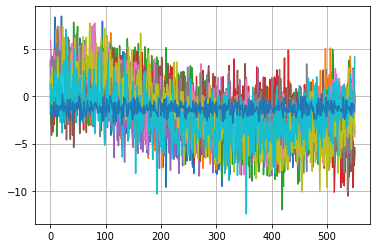

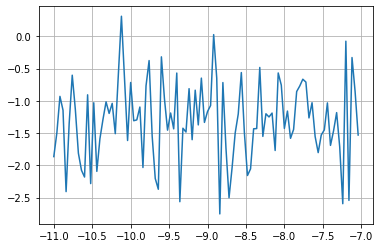

In [13]:
y_predict = result.stan_variable(var='y_predict')

for i in range(10):
    plt.plot(y_predict[i])
mean_value = []
for i in y_predict:
    mean_value.append(np.mean(i))
plt.grid()
plt.plot(mean_value[:550])

plt.figure()

ax = plt.gca()
ax.errorbar(x_predict[0:100], mean_value[0:100])
plt.grid()
plt.draw()

### Task 2: optimize hyperparameters

To achive better results of GP fitting for our observed data, we need to oprimize its parameters. We can do that by using maximum marginal likelihood estimation. It can be done by placing parameters in "parameter" block in stan model and using "optimize" method.

In [23]:
model2 = CmdStanModel(stan_file='gaussian_process_optimize.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [24]:
data = {
    "N_obs": len(y_obs),
    "y_obs": y_obs,
    "x_obs": x_obs
}

In [25]:
result2 = model2.optimize(data=data, seed=5838298)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
rho = result2.stan_variable(var='rho')
alpha = result2.stan_variable(var='alpha')
sigma = result2.stan_variable(var='sigma')
print("rho: {}, alpha: {}, sigma: {}".format(rho, alpha, sigma))

rho: 1.13658, alpha: 3.1811, sigma: 0.196539


Optimize parameters with mentioned method and generate new samples with model from task 1. Of course use just aquired parameters. Do not forget to specify data variable based on stan model. 
What can your say about results in comparison to ones from task 1?
Did the GP perform well in the task of regression? 

In [29]:
data = dict(
    N_predict = len(x_predict),
    x_predict = x_predict,
    N_obs = len(y_obs),
    y_obs = y_obs,
    observed_idx= observed_idx,
    rho = rho,
    alpha = alpha,
    sigma = sigma)

In [30]:
result3 = model.sample(data=data, chains = 4)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


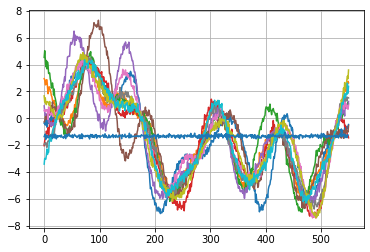

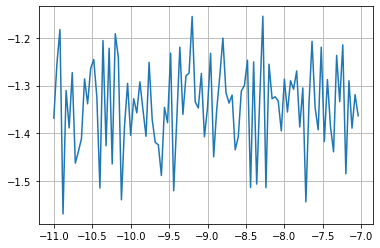

In [31]:
y_predict = result3.stan_variable(var='y_predict')

for i in range(10):
    plt.plot(y_predict[i])
mean_value = []
for i in y_predict:
    mean_value.append(np.mean(i))
plt.grid()
plt.plot(mean_value[:550])

plt.figure()

ax = plt.gca()
ax.errorbar(x_predict[0:100], mean_value[0:100])
plt.grid()
plt.draw()